In [130]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt



In [ ]:
# Load dataset
df = pd.read_csv("movie_summary.csv")

# Filter as previously done
import pandas as pd

# Load dataset
df = pd.read_csv("movie_summary.csv")

# Corrected filtering
df = df[
    (df['production_year'] > 2000) &
    (df['genre'].isin([
        "Romantic Comedy",
        "Thriller/Suspense",
        "Comedy",
        "Drama"
    ])) &
    (df['production_budget'] > 10000) &
    (df['production_budget'] < 5000000) &
    (df['genre'].notna()) &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna() &
    df['production_budget'].notna()
].copy()


print(df.shape)  # no parentheses after shape



(658, 23)


                             OLS Regression Results                             
Dep. Variable:     log_total_box_office   R-squared:                       0.130
Model:                              OLS   Adj. R-squared:                  0.128
Method:                   Least Squares   F-statistic:                     63.83
Date:                  Tue, 27 May 2025   Prob (F-statistic):           1.27e-14
Time:                          22:38:18   Log-Likelihood:                -1062.0
No. Observations:                   429   AIC:                             2128.
Df Residuals:                       427   BIC:                             2136.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6464      1.805

/Users/albert/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


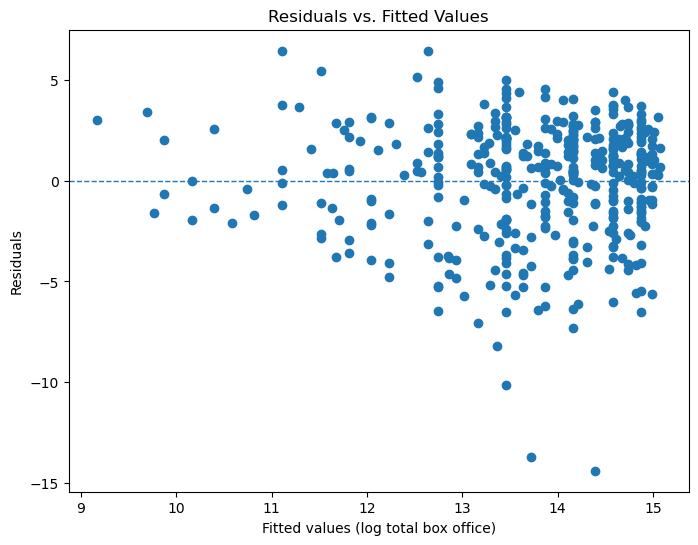

In [213]:
# Load dataset
df = pd.read_csv("movie_summary.csv")

# Filter as previously done
df = df[
    (df['production_year'] > 2000) &
    (df['genre'] != "Reality") &
    (df['domestic_box_office'] < 50000000) &
    (df['international_box_office'] < 50000000) &
    (df['production_budget'] != 0) &
    (df['domestic_box_office'] != 0) &
    df['genre'].notna() &
    df['domestic_box_office'].notna()
].copy()

df['log_domestic_box_office'] = np.log1p(df['domestic_box_office'])
df['log_budget'] = np.log1p(df['production_budget'])
df['total_box_office'] = df['domestic_box_office'] + df['international_box_office']
df['log_total_box_office'] = np.log1p(df['total_box_office'])
df['profit'] = df['domestic_box_office'] - df['production_budget']
df['log_profit'] = np.log1p(df['profit'])
df['log10_budget'] = np.log10(df['production_budget'] + 1)

df['log2_budget']  = np.log2(df['production_budget'] + 1)
df['log2_total_box_office']  = np.log2(df['total_box_office'] + 1)
df['log2_total_box_office']  = np.log2(df['total_box_office'] + 1)
df['sqrt1p_budget'] = np.sqrt(df['production_budget'] + 1)
df['sqrt1p_total_box_office'] = np.sqrt(df['total_box_office'] + 1)



# Drop rows with missing engineered values
df = df.dropna(subset=['log_total_box_office', 'log_budget', 'genre','production_year','theatrical_engagements','creative_type', 'running_time'])

# Linear regression formula
formula = 'log_total_box_office ~  log_budget'

# Fit the model
model = smf.ols(formula, data=df).fit()

# Print the summary
print(model.summary())


# assuming `model` is your fitted OLS results object
fitted_vals = model.fittedvalues
residuals  = model.resid

plt.figure(figsize=(8, 6))
plt.scatter(fitted_vals, residuals)
plt.axhline(0, linewidth=1, linestyle='--')  # horizontal zero line
plt.xlabel('Fitted values (log total box office)')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

Dropping 15 observations with Cook’s D > 0.0093
                             OLS Regression Results                             
Dep. Variable:     log_total_box_office   R-squared:                       0.201
Model:                              OLS   Adj. R-squared:                  0.199
Method:                   Least Squares   F-statistic:                     103.9
Date:                  Tue, 27 May 2025   Prob (F-statistic):           6.53e-22
Time:                          22:38:20   Log-Likelihood:                -973.84
No. Observations:                   414   AIC:                             1952.
Df Residuals:                       412   BIC:                             1960.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

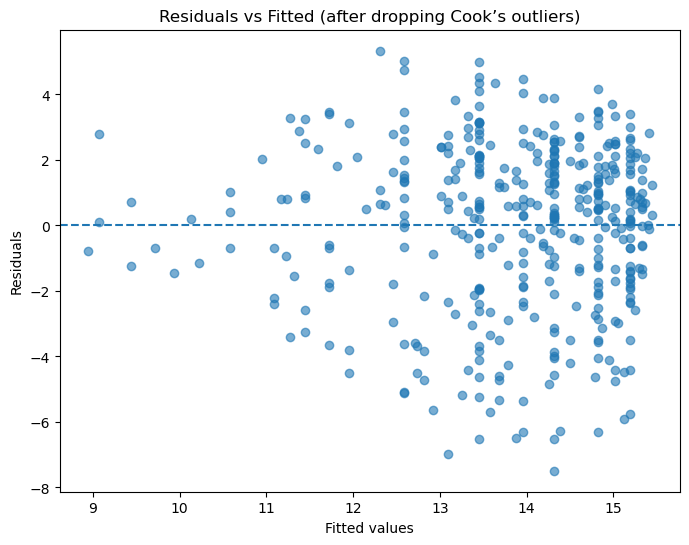

In [214]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# 1. Recompute influence and Cook’s D
influence = model.get_influence()
cooks_d, _ = influence.cooks_distance

# 2. Grab the DataFrame that was actually used in fitting (with its original indices)
df_model = model.model.data.frame

# 3. Set your threshold and identify outliers
threshold = 4 / len(df_model)
outlier_mask = cooks_d > threshold
outliers = df_model.index[outlier_mask]
print(f"Dropping {len(outliers)} observations with Cook’s D > {threshold:.4f}")

# 4. Drop them from your original df (so you keep all other engineered columns, etc.)
df_clean = df.drop(index=outliers)

# 5. (Re)drop any remaining NAs in the columns your formula needs
df_clean = df_clean.dropna(subset=[
    'total_box_office',
    'production_budget',
    'theatrical_engagements',
    'running_time',
    # plus any categorical fields in the formula…
])

# 6. Refit the same formula on the cleaned data
model_clean = smf.ols(formula, data=df_clean).fit()
print(model_clean.summary())

# 7. (Optional) New residual plot
fitted_clean = model_clean.fittedvalues
resid_clean   = model_clean.resid

plt.figure(figsize=(8,6))
plt.scatter(fitted_clean, resid_clean, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (after dropping Cook’s outliers)')
plt.show()


In [134]:
# Feature Engineering
df['log_international_box_office'] = np.log1p(df['international_box_office'])

df = df.dropna(subset=['log_total_box_office','log_international_box_office', 'log_budget', 'genre','production_year','theatrical_engagements','creative_type'])

# Linear regression formula
formula = 'log_international_box_office ~ log_budget + C(genre) + production_year + theatrical_engagements + creative_type'

# Fit the model
model = smf.ols(formula, data=df).fit()

# Print the summary
print(model.summary())

                                 OLS Regression Results                                 
Dep. Variable:     log_international_box_office   R-squared:                       0.232
Model:                                      OLS   Adj. R-squared:                  0.205
Method:                           Least Squares   F-statistic:                     8.510
Date:                          Tue, 27 May 2025   Prob (F-statistic):           4.04e-23
Time:                                  21:52:17   Log-Likelihood:                -1950.2
No. Observations:                           613   AIC:                             3944.
Df Residuals:                               591   BIC:                             4042.
Df Model:                                    21                                         
Covariance Type:                      nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-

In [43]:
formula = 'log_total_box_office ~  C(genre) + C(creative_type)  + theatrical_engagements'

# Fit the model
model = smf.ols(formula, data=df).fit()

# Print the summary
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     log_total_box_office   R-squared:                       0.503
Model:                              OLS   Adj. R-squared:                  0.498
Method:                   Least Squares   F-statistic:                     116.0
Date:                  Tue, 27 May 2025   Prob (F-statistic):          1.88e-313
Time:                          17:38:28   Log-Likelihood:                -4156.9
No. Observations:                  2203   AIC:                             8354.
Df Residuals:                      2183   BIC:                             8468.
Df Model:                            19                                         
Covariance Type:              nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------